In [2]:
import pandas as pd
import geopandas as gpd
from src.Candidate import Candidate
from src.Constituency import Constituency
from src.Constituent import Constituent
from src.Names import *
import numpy as np
import math
import matplotlib.pyplot as plt


In [3]:
election_data = pd.read_csv('Data/HoC-GE2019-results-by-constituency.csv')

In [4]:
election_data.keys()

Index(['ONS ID', 'ONS region ID', 'Constituency name', 'County name',
       'Region name', 'Country name', 'Constituency type', 'Declaration time',
       'Member first name', 'Member surname', 'Member gender', 'Result',
       'First party', 'Second party', 'Electorate', 'Valid votes',
       'Invalid votes', 'Majority', 'Con', 'Lab', 'LD', 'Brexit', 'Green',
       'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'Alliance',
       'All other candidates', 'Of which other winner'],
      dtype='object')

In [5]:
election_data.tail()

,ONS ID,ONS region ID,Constituency name,County name,Region name,Country name,Constituency type,Declaration time,Member first name,Member surname,...,Green,SNP,PC,DUP,SF,SDLP,UUP,Alliance,All other candidates,Of which other winner
645,E14001059,E12000002,Wythenshawe and Sale East,Greater Manchester,North West,England,Borough,43812.21111,Michael,Kane,...,1559,0,0,0,0,0,0,0,58,0
646,E14001060,E12000009,Yeovil,Somerset,South West,England,County,43812.22778,Marcus,Fysh,...,1629,0,0,0,0,0,0,0,875,0
647,W07000041,W92000004,Ynys Môn,Gwynedd,Wales,Wales,County,43812.11458,Virginia,Crosbie,...,0,0,10418,0,0,0,0,0,0,0
648,E14001061,E12000003,York Central,North Yorkshire,Yorkshire and The Humber,England,Borough,43812.17917,Rachael,Maskell,...,2107,0,0,0,0,0,0,0,691,0
649,E14001062,E12000003,York Outer,North Yorkshire,Yorkshire and The Humber,England,County,43812.19097,Julian,Sturdy,...,0,0,0,0,0,0,0,0,692,0


In [6]:
def calculate_bias(row):
    resutls =  np.array([
        row['Con'],
        row['Lab'],
        row['LD'],
        row['Brexit'],
        row['Green'],
        row['SNP'],
        row['PC'],
        row['DUP'],
        row['SF'],
        (row['SDLP']+row['UUP']+row['Alliance']+row['All other candidates'])
    ])
    total = sum(resutls)
    return resutls/total


In [7]:
election_data['bias'] = election_data.apply(calculate_bias, axis=1)

In [8]:
election_data['bias'][200]

array([0.59681689, 0.13816385, 0.19406936, 0.        , 0.03920255,
       0.        , 0.        , 0.        , 0.        , 0.03174736])

In [9]:
def build_candidate_list(parties):
    candidate_list = [Candidate(generate_name(),party, np.random.uniform(0,1),np.random.normal()) for party in parties if party != 'Independent']
    #for i in range(np.random.randint(1,3)):
    #    candidate_list.append(Candidate(generate_name(),'Independent', np.random.uniform(0,1),np.random.normal()))
    return candidate_list

def constituency_bias(national_bias):
    local_bias = [1000*abs(np.random.normal(bias,0.005)) for bias in national_bias]
    local_bias = [bias/sum(local_bias) for bias in local_bias]
    return local_bias

In [10]:
def buid_uk(election_data,parties):
    uk = []
    for index, row in election_data.iterrows():
        uk.append(Constituency(
            row['Constituency name'],
            row['ONS ID'],
            math.ceil(row['Electorate']/100),
            build_candidate_list(parties),
            parties,
            row['bias']))
    return uk

In [11]:
parties = ['Con','Lab','LD','Brexit','Green','SNP','PC','DUP','SF','Independent']
simulated_uk = buid_uk(election_data,parties)

In [12]:
def first_past_the_post(voters, candidates):
    catagories = [candidate.party for candidate in candidates]
    catagories = pd.Series(catagories).unique()
    election_results = pd.DataFrame(columns = catagories, index = range(1))
    election_results = election_results.fillna(0)
    for voter in voters:
        vote = voter.vote(candidates)
        election_results[vote.party] += 1
    election_results['First party']= election_results.idxmax(axis=1)
    return election_results

In [13]:
test_restults = simulated_uk[0].run_election(0.7,first_past_the_post)

In [14]:
test_restults.head()

,Con,Lab,LD,Brexit,Green,SNP,PC,DUP,SF,First party,name,ONS ID,Electorate,Turnout
0,59,192,15,59,3,0,24,0,3,Lab,Aberavon,W07000049,508,0.7


In [15]:
simulated_election_list = [constituency.run_election(np.random.uniform(0.45,0.85),first_past_the_post) for constituency in simulated_uk]


In [16]:
simulated_election = pd.concat(simulated_election_list)
simulated_election.reset_index(drop=True, inplace=True)
simulated_election.head()

,Con,Lab,LD,Brexit,Green,SNP,PC,DUP,SF,First party,name,ONS ID,Electorate,Turnout
0,68,222,14,54,8,0,32,0,1,Lab,Aberavon,W07000049,508,0.787238
1,105,92,6,0,0,0,15,0,0,Con,Aberconwy,W07000058,447,0.489307
2,57,37,23,13,6,158,0,0,0,SNP,Aberdeen North,S14000001,625,0.471456
3,150,23,38,0,0,214,0,0,0,SNP,Aberdeen South,S14000002,658,0.647254
4,110,159,26,0,6,224,0,0,0,SNP,Airdrie and Shotts,S14000003,641,0.819552


In [17]:
simulated_election.tail()

,Con,Lab,LD,Brexit,Green,SNP,PC,DUP,SF,First party,name,ONS ID,Electorate,Turnout
645,167,352,42,47,13,1,0,0,1,Lab,Wythenshawe and Sale East,E14001059,764,0.816316
646,218,26,131,0,14,0,0,0,0,Con,Yeovil,E14001060,825,0.472503
647,116,85,0,21,0,0,83,0,0,Con,Ynys Môn,W07000041,520,0.586859
648,162,308,32,25,23,0,4,0,0,Lab,York Central,E14001061,749,0.739794
649,262,180,113,0,1,0,0,0,0,Con,York Outer,E14001062,747,0.745023


In [18]:
party_colors = {
   "Con":"#0087dc", 
   "LD":"#FDBB30", 
   "Lab":"#d50000", 
   "SNP":"#FFF95D", 
   "PC":"#3F8428",
   "Green": "#6AB023",
   "DUP":"#D46A4C",
   "SF":"#326760", 
}
simulated_election['winner_fill'] = simulated_election['First party'].apply(lambda s: party_colors.get(s, '#aaaaaa'))


In [19]:
uk_boundaries = gpd.read_file('Data/GB/GB_Constituencies_2023.shp')
uk_boundaries.rename(columns={'CODE':'ONS ID'},inplace=True)


In [20]:
resutls = uk_boundaries.merge(simulated_election, on='ONS ID')

/home/zak/miniconda3/envs/Elections/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-32874.78264000016, 688795.96584, -55414.993539999996, 1281058.68434)

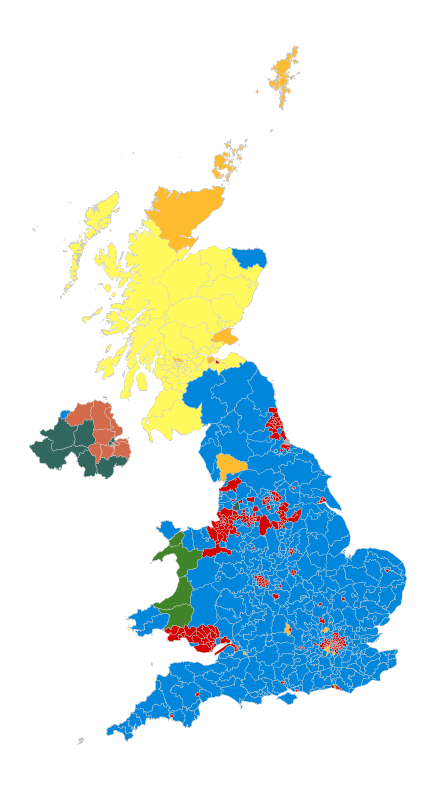

In [21]:
resutls.plot(column='First party', color=resutls['winner_fill'], linewidth=0.2, edgecolor='0.8', legend=True, legend_kwds={'label': "Party", 'orientation': "horizontal", 'pad': 0.01, 'shrink': 0.2, 'aspect': 20, 'fraction': 0.05, 'anchor': (0.5, 0.5)}, figsize=(15, 10))
plt.axis('off')

In [22]:
resutls.head()

,NAME,ONS ID,geometry,Con,Lab,LD,Brexit,Green,SNP,PC,DUP,SF,First party,name,Electorate,Turnout,winner_fill
0,Aberavon,W07000049,"POLYGON ((277338.188 183355.648, 277331.315 18...",68,222,14,54,8,0,32,0,1,Lab,Aberavon,508,0.787238,#d50000
1,Aberconwy,W07000058,"POLYGON ((287117.800 344607.497, 287115.797 34...",105,92,6,0,0,0,15,0,0,Con,Aberconwy,447,0.489307,#0087dc
2,Aberdeen North,S14000001,"POLYGON ((384027.404 806411.397, 384415.400 80...",57,37,23,13,6,158,0,0,0,SNP,Aberdeen North,625,0.471456,#FFF95D
3,Airdrie and Shotts,S14000003,"POLYGON ((274977.098 672604.599, 274978.729 67...",110,159,26,0,6,224,0,0,0,SNP,Airdrie and Shotts,641,0.819552,#FFF95D
4,Aldershot,E14000530,"POLYGON ((483364.601 160961.804, 483370.702 16...",242,88,59,0,12,0,0,0,0,Con,Aldershot,727,0.551930,#0087dc


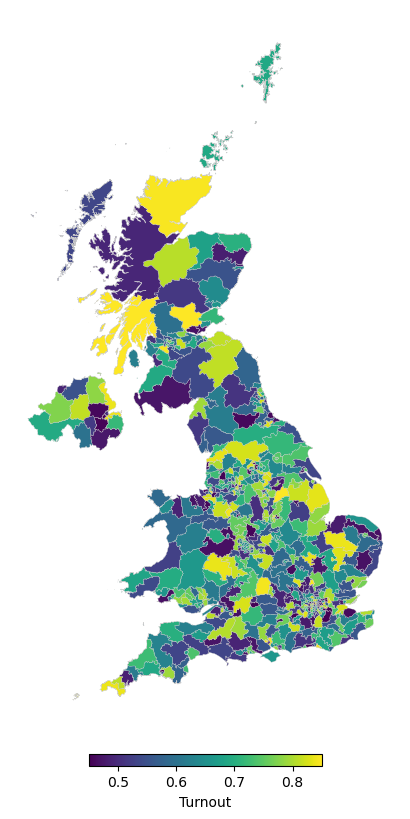

In [23]:
resutls.plot(column='Turnout', cmap='viridis', linewidth=0.2, edgecolor='0.8', legend=True, legend_kwds={'label': "Turnout", 'orientation': "horizontal", 'pad': 0.01, 'shrink': 0.2, 'aspect': 20, 'fraction': 0.05, 'anchor': (0.5, 0.5)}, figsize=(15, 10))
plt.axis('off')
plt.savefig('UK_Election_2019_Turnout.pdf', format='pdf', bbox_inches='tight')

In [24]:
print('Election Results')
print(simulated_election['First party'].value_counts())

Election Results
First party
Con       362
Lab       201
SNP        50
LD         13
DUP         9
SF          8
PC          4
Brexit      2
Green       1
Name: count, dtype: int64


In [26]:
print(simulated_election[simulated_election['First party'] == 'Brexit'])

     Con  Lab  LD  Brexit  Green  SNP  PC  DUP  SF First party           name  \
36     8   17   8     216     17   82  51  182   7      Brexit  Belfast South   
268   75  107  21     122      0    0   0    0   0      Brexit     Hartlepool   

        ONS ID  Electorate   Turnout winner_fill  
36   N06000003         700  0.840456     #aaaaaa  
268  E14000733         709  0.459012     #aaaaaa  
